# Identify covid19 signatures from cough audio

**Oumaima kacem**

**Introduction**

Audio signals generated by the human body (e.g., sighs, breath-
ing, heart, digestion, vibration sounds) have often been used by
clinicians and clinical researchers in diagnosis and monitoring of
disease.

Here, We present a machine learning based COVID-19 cough classifier which is able to discriminate COVID-19 positive coughs
from both COVID-19 negative and healthy coughs recorded on a smartphone. This type of screening is non-contact and easily applied,
and could help reduce workload in testing centers as well as limit transmission by recommending early self-isolation to those who have
a cough suggestive of COVID-19.

**Main contribution**

* Build a deep neural network that can identify covid19 patients based on audio cough

**Data Description**

We used coswara data set for the sake of this analysis. The publicly available dataset contains 92 COVID-19 positive and 1079 healthy subjects.
To get the data you can clone it directly from: https://github.com/iiscleap/Coswara-Data.git

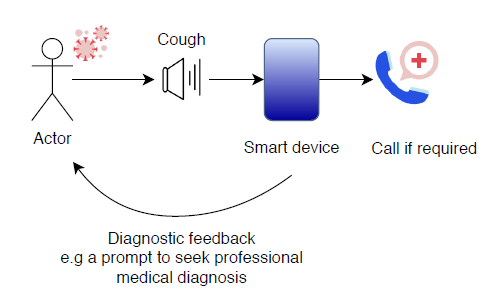

In [ ]:
from IPython.display import Image
Image(filename='Fig1.png') 


In [ ]:
# install libraries
!pip install nlpaug
!pip install keras-tuner
!pip install librosa
# import libraries
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
# keras tuner for hyperparameter tuning 
#requirestensoflow 2.0.0 or more
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import os
import math
import json
import pandas as pd
import keras
from tensorflow.keras import regularizers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import glob
import collections
import shutil
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, History
from keras import regularizers
import keras.backend as K

# Combine  and Prepare the data folders 

In [ ]:
#This file contains all names of cough audio id with the diagnosis of the patient( healthy or weather he has positive symptoms of covid19)
base=pd.read_csv("/content/drive/My Drive/detecting covid19 from audio data/data/combined_data.csv" )

In [ ]:
# result required : obtain covid and healthy folders . each record has the name of the folder in it and compare the statue using combine-data.csv
file_names=[]
all_dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data"
base=pd.read_csv("/content/drive/My Drive/detecting covid19 from audio data/data/combined_data.csv")
condition=[]

for i,(dirpath, dirnames,filenames)in enumerate(os.walk(all_dataset_path)):
   # ensure that we are in the path of all folders that are in dataset_path
   if dirpath is not all_dataset_path:
     for f in filenames:
       file_path=os.path.join(dirpath, f)
       file_names.append(file_path)
       file_condition=file_path.split("/")
       file_condition=file_condition[-1]
       #print('checking this file:',dirpath)
       dirpaths=dirpath.split("/")
       if any( base['id']==dirpaths[-1]):
         print('audio exist in combined-data')
         j=base.index[base['id'] == dirpaths[-1]]
         condition=base['covid_status'].loc[j[0]]
         if condition =='healthy':
           print('healthy')
           ### get only heavy cough 
           if (file_path.split('/'))[-1]=='cough-heavy.wav':
             print("moving", file_path,"to healthy file")
             shutil.copy(file_path, '/content/drive/My Drive/detecting covid19 from audio data/data_healthy')
             audio_name=(file_path.split('/'))[-2]
             os.rename('/content/drive/My Drive/detecting covid19 from audio data/data_healthy/cough-heavy.wav','/content/drive/My Drive/detecting covid19 from audio data/data_healthy/'+'cough-heavy_'+ audio_name +'.wav')
         else: 
           if (condition =='positive_asymp')| (condition =='positive_mild')|(condition =='positive_moderate'):
             if (file_path.split('/'))[-1]=='cough-heavy.wav':
               print("moving",file_path,"to covid file")
               shutil.copy(file_path,'/content/drive/My Drive/detecting covid19 from audio data/data_covid')
               audio_name=(file_path.split('/'))[-2]
               os.rename(file_path,'/content/drive/My Drive/detecting covid19 from audio data/data_covid/'+'cough-heavy_'+audio_name+'.wav')   

# Cleaning data

In [ ]:
n_fft=2048
hop_length=512
sample_rate=22050
duration=1 # duration of each record
sample_per_track=sample_rate*duration

In [ ]:
######## import data
dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data"

In [ ]:
##### check duplicated audio file
file_names=[]
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):
   # ensure that we are in the path of all folders that are in dataset_path
   if dirpath is not dataset_path:
     print(dirpath)
     print('number of audio data in each folder',len(glob.glob1(dirpath,"*.wav")))
     for f in filenames:
       file_path=os.path.join(dirpath, f)
       file_names.append(file_path)
# We are facing here unbalanced data

/content/drive/My Drive/detecting covid19 from audio data/data_healthy
number of audio data in each folder 446
/content/drive/My Drive/detecting covid19 from audio data/data_covid
number of audio data in each folder 104


In [ ]:
############ chack duration of audio file
# loop through all the audio documents

file_paths=[]
data1={"duration":[]}
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):
   # ensure that we are not in the root path
   if dirpath is not dataset_path:
     print(dirpath)
     dirpath_component=dirpath.split("/")
     # process file for a specific genre
   for f in filenames:
       file_path=os.path.join(dirpath, f)
       print(file_path)
       file_paths.append(file_path)
       signal, sr= librosa.load(file_path)#,sr=sample_rate)
       dur=librosa.get_duration(y=signal, sr=sr)
       data1["duration"].append (dur)


In [ ]:
############### DELETE AUDIO FILE from covid folder because while procesing it did not work for mfcc and when i listened to it there was no coughing , it was ruined
filepaths_to_drop=[]
for i in range(0,len(data1['duration'])):
  if data1['duration'][i] < 1:
    filepaths_to_drop.append(file_paths[i])
    print("index of file",i, "duration of audio file",data1['duration'][i])
    print("check these files",file_paths[i])

index of file 41 duration of audio file 0.6501587301587302
check these files /content/drive/My Drive/detecting covid19 from audio data/data_healthy/cough-heavy_pvLLeiltxePL7csr2rkLJ8fD0gc2.wav
index of file 42 duration of audio file 0.0
check these files /content/drive/My Drive/detecting covid19 from audio data/data_healthy/cough-heavy_kgjTguvo3vZJTO7F1qO9GxEicbA3.wav
index of file 45 duration of audio file 0.0
check these files /content/drive/My Drive/detecting covid19 from audio data/data_healthy/cough-heavy_DycfRd7vyobY2PgwT3rQOemSbP53.wav
index of file 47 duration of audio file 0.0
check these files /content/drive/My Drive/detecting covid19 from audio data/data_healthy/cough-heavy_Ts5Rbl9h9pWKqCQPJwoTduGvjMm2.wav
index of file 52 duration of audio file 0.0
check these files /content/drive/My Drive/detecting covid19 from audio data/data_healthy/cough-heavy_JUVJnOVJKKcdzppK3hkci4TO4ij1.wav
index of file 414 duration of audio file 0.8359183673469388
check these files /content/drive/My

In [ ]:
for i in filepaths_to_drop: 
  os.remove(i)

# Processing audio data to get Mel-frequency cepstral coefficients

The generated sound is transmitted through the air as an acoustic wave. This wave is modeled as a sinusoidal harmonic wave. 

Mel-frequency cepstral coefficients (MFCCs) have been used
very successfully as features in audio analysis and especially
in automatic speech recognition. They have also been
found to be useful for differentiating dry coughs from wet
coughs.  The extracted MFCC data are further used as inputs for neural network training.

In [ ]:
################ prepare the dataset
json_path="/content/drive/My Drive/detecting covid19 from audio data/data/data.json" ## to delete if i ever want to rerun all work
def save_mfcc(dataset_path, json_path, n_fft=2048, n_mfcc=13, hop_length=512, num_segments=5):
  # dictionary_to store_data
  data={
      "mapping":[],
      "audio_id":[],
      "mfcc":[],
      "labels":[]
  }
  num_sample_per_segment= int(sample_per_track/num_segments)
  expected_num_samples_per_sements=math.ceil(num_sample_per_segment/hop_length)
  
  # loop through all the genres(documents)
  for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):
   # ensure that we are not in the root path
   if dirpath is not dataset_path:
     print(dirpath)
     dirpath_component=dirpath.split("/")
     semantic_label=dirpath_component[-1]
     data["mapping"].append(semantic_label)
     print("\n processing {}".format(semantic_label))

     # process file for a specific genre
     for f in filenames:
       file_path=os.path.join(dirpath, f)
       signal, sr= librosa.load(file_path,sr=sample_rate)
       # process segments,extracting mfcc and storing data
       for s in range(num_segments):
         start_sample= num_sample_per_segment* s
         finish_sample=start_sample+num_sample_per_segment
  
         mfcc=librosa.feature.mfcc(signal[start_sample:finish_sample],n_fft=n_fft,n_mfcc=13,sr=sr,hop_length=hop_length )
         mfcc=mfcc.T
         # store mfcc if it has the expected length( because they all have to have the same input shape)
         if (len (mfcc)==expected_num_samples_per_sements):
           data["mfcc"].append(mfcc.tolist())
           data["labels"].append(i-1)
           data["audio_id"].append(str(f))
           print("{},segment:{}have been preprocessed".format(file_path,s))


  with open(json_path,"w") as fp:
    json.dump(data,fp, indent=4)


In [ ]:
save_mfcc(dataset_path,json_path ,num_segments=5 )

# Split data into training, validation and test datasets

In [ ]:
# read the data 
data_path="/content/drive/My Drive/detecting covid19 from audio data/data/data.json"
def load_data(data_path):
  # loading data from json file
  # return X as variables and Y as targets
  with open (data_path,"r")as fp:
    data=json.load(fp)
  X=np.array( data["mfcc"])
  y=np.array(data["labels"])
  id=data["audio_id"]
  return X,y,id

In [ ]:
X,y,id = load_data(data_path)

In [ ]:
# split data into training, validation and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify=y_train)
#X_train.shape, y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

# Prepare the input data shape for the deep learning model

In [ ]:
# Prepare data shape so it can match the requirement of convolutional neural network model 
# what we have now is 3d array (130:time_bins,13:mfcc,1:depth)
# we need to have 4d array by adding number of samples for cnn
X_train=X_train[...,np.newaxis]
X_val=X_val[...,np.newaxis]
X_test=X_test[...,np.newaxis]
print('shape of training data',X_train.shape) # as a grayscale image
input_shape_cnn= (X_train.shape[1],X_train.shape[2],X_train.shape[3])
# it is 3d but it gets none and in fit function, we have to provide X-train as a four dimension

shape of training data (1980, 9, 13, 1)


In [ ]:
input_shape_cnn

(9, 13, 1)

In [ ]:
  model.add(Conv2D(16,(3,3),activation="relu"))
  #model.add(MaxPooling2D((2,2),padding="same"))
  model.add(BatchNormalization())### to sped training the model is gonna converge faster and be more reliable 
  model.add(MaxPooling2D((2,2),padding="same"))
  model.add(Dropout(0.3))

# Building the model  for audio classification 

In [ ]:
# Building the model that is going to be used for audio classification 
checkpoints_path='/content/drive/My Drive/detecting covid19 from audio data/data/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
reg = regularizers.l1_l2(l1=0.001, l2=0.00)
def build_model (input_shape_cnn):
  # create model
  model=keras.Sequential()
  # 1st conv layer
  model.add(Conv2D(16,(3,3),activation="relu", input_shape=input_shape_cnn))
  model.add(MaxPooling2D((3,3),padding="same"))
  model.add(BatchNormalization())### to speed training the model is gonna converge faster and be more reliable 
  model.add(Dropout(0.4))
 
  #2nd conv 
  model.add(Conv2D(16,(3,3),activation="relu"))
  #model.add(MaxPooling2D((2,2),padding="same"))
  model.add(BatchNormalization())### to sped training the model is gonna converge faster and be more reliable 
  model.add(Dropout(0.3))



  # flatten the output and feed it into dense layer
  model.add(Flatten())
  model.add(Dense(32,activation="relu"))
  model.add(Dense(32,activation="relu"))
  model.add(Dense(32,activation="relu"))

  model.add(Dropout(0.2))
  # output layer
  model.add(Dense(2, activation="sigmoid"))
  
  return model

model=build_model (input_shape_cnn)
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 11, 16)         160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 4, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 4, 16)          64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 4, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 2, 16)          2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 2, 16)          64        
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 2, 16)         

In [ ]:
# compile the model before fitting 
optimizer= optimizers.Adam(lr=1e-3)
#checkpoint of the model (based on val_loss)
checkpoint = ModelCheckpoint(checkpoints_path, verbose=1, save_weights_only=True, save_best_only=True)
#early stopping
earlyStopping = EarlyStopping(patience = 30, verbose=1)
#learning rate reduction
reducelr = ReduceLROnPlateau(verbose = 1, patience= 10)
#terminating on NaN loss values
nanStopping = TerminateOnNaN()
#callbacks
callbacks_list = [checkpoint, earlyStopping,reducelr,nanStopping]

model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["accuracy"])

In [ ]:
#training the cnn model
model_history= model.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=32, epochs=100,verbose=1, shuffle=True,callbacks=callbacks_list)

Epoch 1/100
62/62 [==============================] - 1s 7ms/step - loss: 0.2243 - accuracy: 0.4830 - val_loss: 0.1533 - val_accuracy: 0.2682

Epoch 00001: val_loss improved from inf to 0.15330, saving model to /content/drive/My Drive/detecting covid19 from audio data/data/checkpoints/weights.01-0.15.hdf5
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1676 - accuracy: 0.5143 - val_loss: 0.1548 - val_accuracy: 0.7318

Epoch 00002: val_loss did not improve from 0.15330
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1567 - accuracy: 0.5365 - val_loss: 0.1540 - val_accuracy: 0.6591

Epoch 00003: val_loss did not improve from 0.15330
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1491 - accuracy: 0.5037 - val_loss: 0.1536 - val_accuracy: 0.6909

Epoch 00004: val_loss did not improve from 0.15330
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1566 - accuracy: 0.4960 - val_loss: 0.15

# Evaluating the performance of the model

18/18 [==============================] - 0s 3ms/step - loss: 0.1427 - accuracy: 0.5945
Test accuracy: 0.5945454835891724
Test loss: 0.14266270399093628


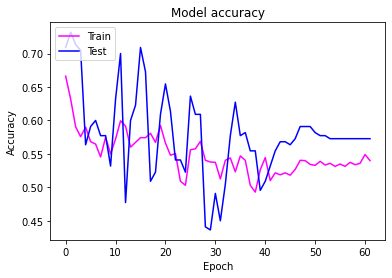

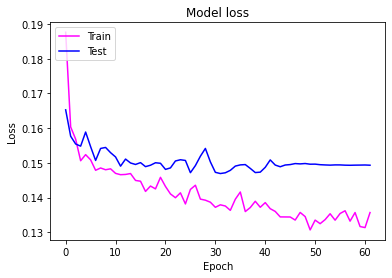

In [ ]:
# evaluating the performance of the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'],color='magenta')
plt.plot(model_history.history['val_accuracy'],color='blue')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'],color='magenta')
plt.plot(model_history.history['val_loss'],color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    import itertools    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[271 175]
 [ 48  56]]


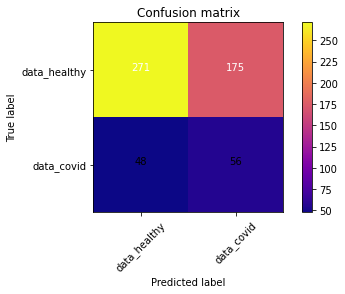

In [ ]:
y_pred= model.predict_on_batch(X_test)
# y_pred is two dimentional so we need to extract index with max value
y_pred1= np.argmax(y_pred,axis=1)
# confusion matrix display
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred1)
with open (data_path,"r")as fp:
    data=json.load(fp)
cm_plot_labels=data["mapping"]
plot_confusion_matrix(cm,classes= cm_plot_labels,title='Confusion matrix',cmap='plasma')

# Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning of the model
def build_model(hp):  
  model = Sequential([
    Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(X_train.shape[1],X_train.shape[2],1)
    ),
  
    MaxPooling2D((3,3),padding="same"),
    Dropout(0.2),
    Conv2D(
        filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [2]),
        activation='relu'
    ),
    Dropout(0.3),
 
  
    Flatten(),
    Dense(
        units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ),
    Dropout(0.2),
    Dense(
        units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ),
    Dropout(0.2),

    Dense(2, activation='sigmoid'),
    ])
  
  model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='mean_squared_error',
              metrics=['accuracy'])
  
  return model


In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=10,directory='output')
tuner_search.search(X_train, y_train,epochs=5,validation_data=(X_val,y_val))# to change with validation set because tuning must be performed with it
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 11, 32)         320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 9, 48)          13872     
_________________________________________________________________
dropout (Dropout)            (None, 5, 9, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2160)              0         
_________________________________________________________________
dense (Dense)                (None, 112)               242032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               1

In [ ]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), initial_epoch=3)

Epoch 4/100
62/62 [==============================] - 1s 6ms/step - loss: 0.3981 - accuracy: 0.8366 - val_loss: 0.4897 - val_accuracy: 0.8273
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.8278 - val_loss: 0.6214 - val_accuracy: 0.8091
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3946 - accuracy: 0.8287 - val_loss: 0.5814 - val_accuracy: 0.8136
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3694 - accuracy: 0.8382 - val_loss: 0.5915 - val_accuracy: 0.8182
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3543 - accuracy: 0.8454 - val_loss: 0.6497 - val_accuracy: 0.8136
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3424 - accuracy: 0.8464 - val_loss: 0.7883 - val_accuracy: 0.8182
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3003 - accuracy: 0.8660 - val_loss: 0.7198 - val_accuracy: 0.8227
Epoch 11/100

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

1/1 [==============================] - 0s 114ms/step - loss: 5.1091 - accuracy: 0.6562
Test accuracy: 0.65625
Test loss: 5.109078407287598


# Data augmentation techniques for audio data:

One should augment the data after Train and Test split. To work correctly one needs to make sure to augment data only from the train split.

If one augments data and before splitting the dataset, it will likely inject small variations of the train dataset into the test dataset. Thus the network will be overestimating its accuracy (and it might be over-fitting as well, among other issues).

A good way to avoid this pitfall it is to augment the data after the original dataset was split.



In [ ]:
import glob 
import shutil
from shutil import copyfile

In [ ]:
### merge the two datasets and copy in one folder in a new path  

dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data"
data_gen_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen"
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):  
  if ((dirpath is not dataset_path) & (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data_gen")& (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data/checkpoints")):
    print("check files for merging ", dirpath)
    print(filenames)
    folder=dirpath.split("/")[-1]
    print(folder)
    for my_filename in glob.glob(dirpath+ "/*.wav"):
      print(my_filename)
      #if folder =='data_healthy':
      destination_path= "/content/drive/My Drive/detecting covid19 from audio data/data_gen/"+ (my_filename.split("/")[-1])
      shutil.copyfile(my_filename,destination_path)   

In [ ]:
# split train, test data based on id and labels and stratify y
training_data,testing_data,y_training_data,y_testing_data=train_test_split(audio_names,audio_label,test_size=0.2,random_state=42,stratify=audio_label)

In [ ]:
import os
# define the name of the directory to be created
paths = ["/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/healthy_data","/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/covid_data","/content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/healthy_data","/content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/covid_data","/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated"]
for path in paths:
  try:
    os.makedirs(path)
  except OSError:
    print ("Creation of the directory %s failed" % path)
  else:
    print ("Successfully created the directory %s " % path)



Successfully created the directory /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/healthy_data 
Successfully created the directory /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/covid_data 
Successfully created the directory /content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/healthy_data 
Successfully created the directory /content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/covid_data 


In [ ]:
### create folder ( train_healthy, train_covid) and folder ( test_healthy, test_covid)
#dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data"
##### for training data
#data_gen_path
dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen"
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(data_gen_path)):  
  if ((dirpath is not dataset_path) & (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data_gen/data_healthy")& (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data_gen/data_covid")) & (dirpath not in paths):
    print("splitting files to healthy and covid ", dirpath)
    for my_filename in glob.glob(dirpath+ "/*.wav"):
      print(my_filename)
      if my_filename. split("/")[-1] in training_data:
        print("this file is in training data", my_filename)
        ### check folder ( covid or healthy from the name of the file) if filename heka 
        audio=my_filename. split("/")[-1] 
        print("audio name",audio)
        indice=id.index(audio)
        print('label',y[indice])
        if (y[id.index(audio)]) == 0:
          destination_path= "/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/healthy_data/"+ (my_filename.split("/")[-1])
          print(destination_path)
          print(my_filename)
          shutil.copyfile(my_filename,destination_path)
        if  (y[id.index(audio)] == 1):
          destination_path= "/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/covid_data/"+ (my_filename.split("/")[-1])
          shutil.copyfile (my_filename,destination_path)
      if my_filename. split("/")[-1] in testing_data:
        print("this file is in testing data", my_filename)
        ### check folder ( covid or healthy from the name of the file) if filename heka 
        audio=my_filename. split("/")[-1] 
        if y[id.index(audio)]== 0:
          destination_path= "/content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/healthy_data/"+ (my_filename.split("/")[-1])
          shutil.copyfile(my_filename,destination_path)
        if  y[id.index(audio)]== 1:
          destination_path= "/content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/covid_data/"+ (my_filename.split("/")[-1])
          shutil.copyfile (my_filename,destination_path)
        

In [ ]:
print(librosa.__version__)
import soundfile as sf

0.8.0


In [ ]:
'''
Augmenter that apply pitch adjustment operation to audio
sampling_rate (int) – Sampling rate of input audio.
zone (tuple) – Assign a zone for augmentation. Default value is (0.2, 0.8) which means that no any augmentation will be applied in first 20% and last 20% of whole audio.
coverage (float) – Portion of augmentation. Value should be between 0 and 1. If 1 is assigned, augment operation will be applied to target audio segment. For example, the audio duration is 60 seconds while zone and coverage are (0.2, 0.8) and 0.7 respectively. 42 seconds ((0.8-0.2)*0.7*60) audio will be augmented.
duration (int) – Duration of augmentation (in second). Default value is None. If value is provided. coverage value will be ignored.
factor (tuple) – Input data pitch will be increased (decreased). Augmented value will be picked within the range of this tuple value. Pitch will be reduced if value is between 0 and 1.
name (str) – Name of this augmenter
'''
import nlpaug.augmenter.audio as naa
import glob
### keep only training data folders in the if condition 
dataset_path= "/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/" # only training path
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):  
  if ((dirpath is not dataset_path) & (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated")):
    print("data augmentation of ", dirpath)
    for my_filename in glob.glob(dirpath+ "/*.wav"):
      file,sr=librosa.load(my_filename)
      aug = naa.PitchAug(sampling_rate=sr)
      augmented_data=aug.augment(file)
      my_filename_component=my_filename.split("/")
      semantic_label=my_filename_component[-1]
      ## check if healthy or covid 
      # librosa.output.write_wav('/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/'+'_Pitch_aug'+ semantic_label,augmented_data,sr)
      sf.write('/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/'+'_Pitch_aug_'+ semantic_label,augmented_data,sr)

data augmentation of  /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/healthy_data
data augmentation of  /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/covid_data


In [ ]:
'''
changing the speed of the audio
zone (tuple) – Assign a zone for augmentation. Default value is (0.2, 0.8) which means that no any augmentation will be applied in first 20% and last 20% of whole audio.
coverage (float) – Portion of augmentation. Value should be between 0 and 1. If 1 is assigned, augment operation will be applied to target audio segment. For example, the audio duration is 60 seconds while zone and coverage are (0.2, 0.8) and 0.7 respectively. 42 seconds ((0.8-0.2)*0.7*60) audio will be augmented.
factor (tuple) – Input data speed will be increased (decreased). Augmented value will be picked within the range of this tuple value. Speed will be reduced if value is between 0 and 1.
speed_range (tuple) – Deprecated. Use factor indeed
name (str) – Name of this augmenter
'''
import nlpaug.augmenter.audio as naa
import glob 
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):  
  if ((dirpath is not dataset_path) & (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated")):
    print("data augmentation of ", dirpath)
    for my_filename in glob.glob(dirpath+ "/*.wav"):
      file,sr=librosa.load(my_filename)
      aug = naa.speed.SpeedAug()
      augmented_data=aug.augment(file)
      my_filename_component=my_filename.split("/")
      semantic_label=my_filename_component[-1]
      sf.write('/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/'+'_speed_aug_'+ semantic_label,augmented_data,sr)


data augmentation of  /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/healthy_data
data augmentation of  /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/covid_data


In [ ]:
'''
This process involves addition of noise i.e. white noise to the sample. 
White noises are random samples distributed at regular intervals with mean of 0 and standard deviation of 1
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004

:param tuple zone: Assign a zone for augmentation. Default value is (0.2, 0.8) which means that no any
        augmentation will be applied in first 20% and last 20% of whole audio.
    :param float coverage: Portion of augmentation. Value should be between 0 and 1. If `1` is assigned, augment
        operation will be applied to target audio segment. For example, the audio duration is 60 seconds while
        zone and coverage are (0.2, 0.8) and 0.7 respectively. 42 seconds ((0.8-0.2)*0.7*60) audio will be
        augmented.
    :param str color: Colors of noise. Supported 'white', 'pink', 'red', 'brown', 'brownian', 'blue', 'azure',
        'violet', 'purple' and 'random'. If 'random' is used, noise color will be picked randomly in each augment.
    :param list noises: Background noises for noise injection. You can provide more than one background noise and
        noise will be picked randomly. Expected format is list of numpy array. If this value is provided. `color`
        value will be ignored
    :param str name: Name of this augmenter
'''
import nlpaug.augmenter.audio as naa
import glob  # ensure that we are not in the root path
for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):  
  if ((dirpath is not dataset_path) & (dirpath!="/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated")):
    print("data augmentation of ", dirpath)
    for my_filename in glob.glob(dirpath+ "/*.wav"):
      file,sr=librosa.load(my_filename)
      aug = naa.NoiseAug()
      augmented_data=aug.augment(file)
      my_filename_component=my_filename.split("/")
      semantic_label=my_filename_component[-1]
      sf.write('/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/'+'_noise_aug_'+ semantic_label,augmented_data,sr)


data augmentation of  /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/healthy_data
data augmentation of  /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/covid_data


In [ ]:
## mfcc save == json for training and testing data 
training_generated_json_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/training_generated.json"
testing_json_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/testing.json"
training_generated_dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated"
testing_dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen/testing_data/"


In [ ]:
################ prepare the dataset
dataset_path="/content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated"
audios=[]
def save_mfcc_gen(dataset_path, json_path, n_fft=2048, n_mfcc=13, hop_length=512, num_segments=5):
  # dictionary_to store_data
  data={
      "mapping":[],
      "audio_id":[],
      "mfcc":[],
      "labels":[]
       }
  num_sample_per_segment= int(sample_per_track/num_segments)
  expected_num_samples_per_sements=math.ceil(num_sample_per_segment/hop_length)
  j=0
  for i,(dirpath, dirnames,filenames)in enumerate(os.walk(dataset_path)):
   # ensure that we are not in the root path
   if dirpath is dataset_path:
     print(dirpath)
     #process file for a specific genre
     for f in filenames:
       file_path=os.path.join(dirpath, f)
       #print(f)
       audio=f.split("_")[-2]+"_" + f.split("_")[-1]
       print("\n processing {}".format(audio)) 
       signal, sr= librosa.load(file_path,sr=sample_rate)
       # process segments,extracting mfcc and storing data
       for s in range(num_segments):
         start_sample= num_sample_per_segment* s
         finish_sample=start_sample+num_sample_per_segment  
         mfcc=librosa.feature.mfcc(signal[start_sample:finish_sample],n_fft=n_fft,n_mfcc=13,sr=sr,hop_length=hop_length )
         mfcc=mfcc.T
         # store mfcc if it has the expected length( because they all have to have the same input shape)
         if (len (mfcc)==expected_num_samples_per_sements):
           j=j+1
           print("now this",audio)
           audios.append(audio)
           data["mfcc"].append(mfcc.tolist())
           data["audio_id"].append(str(f.split("/")[-1]))######## need to add augmentation type!!!!!!!! just for the audio_id and remove it while processing labels
           #### get labels from merged dataset labels
           indice=id.index(audio)
           print(indice)
           print(y[id.index(audio)])
           data["labels"].append(y[id.index(audio)])
           data['labels'] = [int(i) for i in data['labels']]
           print("{},segment:{} have been preprocessed",file_path,s)


  print(j)
  with open(training_generated_json_path,"w") as fp:
    json.dump(data,fp,indent=4)

In [ ]:
save_mfcc_gen(training_generated_dataset_path,training_generated_json_path,num_segments=5)

Streaming output truncated to the last 5000 lines.
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_speed_aug_cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav 0
now this cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav
1155
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_speed_aug_cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav 1
now this cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav
1155
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_speed_aug_cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav 2
now this cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav
1155
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_speed_aug_cough-heavy_vwUqgVSWMCWzCNxdD8uE97pk0I53.wav 3


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1814
  n_fft, y.shape[-1]


Streaming output truncated to the last 5000 lines.
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_noise_aug_cough-heavy_L6zbMqqGS1et0kjPXmSsLUI3vz22.wav 3
now this cough-heavy_L6zbMqqGS1et0kjPXmSsLUI3vz22.wav
1335
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_noise_aug_cough-heavy_L6zbMqqGS1et0kjPXmSsLUI3vz22.wav 4

 processing cough-heavy_8XoAGDSPjVWjpjfIDHrIiHd4NEC2.wav
now this cough-heavy_8XoAGDSPjVWjpjfIDHrIiHd4NEC2.wav
1345
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_noise_aug_cough-heavy_8XoAGDSPjVWjpjfIDHrIiHd4NEC2.wav 0
now this cough-heavy_8XoAGDSPjVWjpjfIDHrIiHd4NEC2.wav
1345
0
{},segment:{} have been preprocessed /content/drive/My Drive/detecting covid19 from audio data/data_gen/training_data/data_generated/_n

In [ ]:
### no need to shuffle because data is already shuffled  before merging ans spliting into floders
save_mfcc(testing_dataset_path,testing_json_path ,num_segments=5)

# Evaluating data augmentation performance

In [ ]:
### Prepare the shape of == X_train, y_train, X_val_y_val and get X_test and y_test
# Prepare data shape so it can match the requirement of convolutional neural network model 
# we need to have 4d array by adding number of samples for cnn

# load data after mfcc
X_test,y_test,id_test = load_data(testing_json_path)
X_train_gen,y_train_gen,id_train_gen= load_data(training_generated_json_path)

# split training to training and validation
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train_gen,y_train_gen,test_size=0.1,random_state=42,stratify=y_train_gen)

#prepare input shapes
X_train=X_train[...,np.newaxis]
X_val=X_val[...,np.newaxis]
X_test=X_test[...,np.newaxis]
print('shape of training data',X_train.shape) # as a grayscale image
input_shape_cnn= (X_train.shape[1],X_train.shape[2],X_train.shape[3])
# it is 3d but it gets none and in fit function, we have to provide X-train as a four dimension

shape of training data (5939, 9, 13, 1)


In [ ]:
# Rerun model after data generation
optimizer= optimizers.Adam(lr=1e-3)
#checkpoint of the model (based on val_loss)
checkpoint = ModelCheckpoint(checkpoints_path, verbose=1, save_weights_only=True, save_best_only=True)
#early stopping
earlyStopping = EarlyStopping(patience = 30, verbose=1)
#learning rate reduction
reducelr = ReduceLROnPlateau(verbose = 1, patience= 10)
#terminating on NaN loss values
nanStopping = TerminateOnNaN()
#callbacks
callbacks_list = [checkpoint, earlyStopping,reducelr,nanStopping]

model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["accuracy"])
#model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#training the cnn model
model_history= model.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=32, epochs=200,verbose=1, shuffle=True,callbacks=callbacks_list)

Epoch 1/200
186/186 [==============================] - 2s 5ms/step - loss: 0.1959 - accuracy: 0.6436 - val_loss: 0.1579 - val_accuracy: 0.6288

Epoch 00001: val_loss improved from inf to 0.15793, saving model to /content/drive/My Drive/detecting covid19 from audio data/data/checkpoints/weights.01-0.16.hdf5
Epoch 2/200
186/186 [==============================] - 1s 3ms/step - loss: 0.1586 - accuracy: 0.5547 - val_loss: 0.1491 - val_accuracy: 0.6348

Epoch 00002: val_loss improved from 0.15793 to 0.14911, saving model to /content/drive/My Drive/detecting covid19 from audio data/data/checkpoints/weights.02-0.15.hdf5
Epoch 3/200
186/186 [==============================] - 1s 3ms/step - loss: 0.1562 - accuracy: 0.5328 - val_loss: 0.1497 - val_accuracy: 0.5591

Epoch 00003: val_loss did not improve from 0.14911
Epoch 4/200
186/186 [==============================] - 1s 3ms/step - loss: 0.1542 - accuracy: 0.5083 - val_loss: 0.1506 - val_accuracy: 0.4985

Epoch 00004: val_loss did not improve fro

18/18 [==============================] - 0s 3ms/step - loss: 0.1455 - accuracy: 0.6127
Test accuracy: 0.6127272844314575
Test loss: 0.14551231265068054


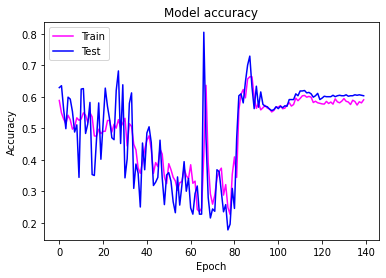

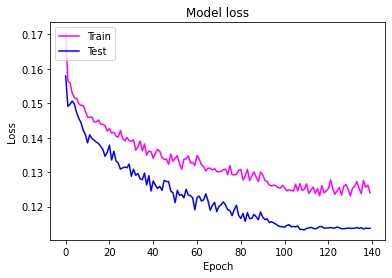

In [ ]:
# evaluating the performance of the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'],color='magenta')
plt.plot(model_history.history['val_accuracy'],color='blue')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'],color='magenta')
plt.plot(model_history.history['val_loss'],color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[286 164]
 [ 49  51]]


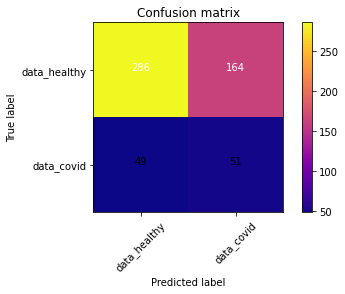

In [ ]:
y_pred= model.predict_on_batch(X_test)
# y_pred is two dimentional so we need to extract index with max value
y_pred1= np.argmax(y_pred,axis=1)
# confusion matrix display
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred1)
with open (data_path,"r")as fp:
    data=json.load(fp)
cm_plot_labels=data["mapping"]
plot_confusion_matrix(cm,classes= cm_plot_labels,title='Confusion matrix',cmap='plasma')